In [8]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import warnings
warnings.filterwarnings("ignore")

In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"GPUs detected: {len(gpus)}")
    except RuntimeError as e:
        print(f"Error setting GPU memory growth: {e}")
else:
    print("No GPUs detected.")

GPUs detected: 1


In [4]:
def data_frame(path):
    class_paths = []
    classes = []

    for label in os.listdir(path):
        class_dir = os.path.join(path, label)
        if os.path.isdir(class_dir):  # Ensure it's a directory
            for image in os.listdir(class_dir):
                class_paths.append(os.path.join(class_dir, image))
                classes.append(label)

    df = pd.DataFrame({'Class Path': class_paths, 'Class': classes})
    return df

In [5]:
train_dataframe = data_frame('/kaggle/input/faysals-work-br/Training')

In [6]:
test_dataframe = data_frame('/kaggle/input/faysals-work-br/Testing')

In [7]:
Validation_dataframe, test_dataframe = train_test_split(test_dataframe, train_size=0.5, random_state=42, stratify=test_dataframe['Class'])

In [9]:
BATCH_SIZE = 32
IMG_SIZE = (299, 299)
EPOCH = 15

In [12]:
data_generator = ImageDataGenerator(
    rescale=1/255.0,
    rotation_range=10,
    shear_range=0.1,
    zoom_range=0.05,
    fill_mode='nearest'
)
test_data_generator = ImageDataGenerator(rescale=1/255)


train_data = data_generator.flow_from_dataframe(train_dataframe, x_col='Class Path',
                                  y_col='Class', batch_size=BATCH_SIZE,
                                  target_size=IMG_SIZE)

validation_data = data_generator.flow_from_dataframe(Validation_dataframe, x_col='Class Path',
                                     y_col='Class', batch_size=BATCH_SIZE,
                                     target_size=IMG_SIZE)

test_data = test_data_generator.flow_from_dataframe(test_dataframe, x_col='Class Path',
                                  y_col='Class', batch_size=BATCH_SIZE,
                                  target_size=IMG_SIZE, shuffle=False)

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


In [13]:
img_shape=(299,299,3)
base_model = tf.keras.applications.Xception(include_top= False, weights= "imagenet",
                            input_shape= img_shape, pooling= 'max')

base_model.trainable = False

inputs = Input(shape = img_shape)

x = base_model(inputs)

x = Flatten()(x)

x = Dropout(rate= 0.3)(x)
x = Dense(128, activation= 'relu')(x)
x = Dropout(rate= 0.25)(x)
x = Dense(4, activation= 'softmax')(x)

model = Model(inputs, x)

model.compile(Adamax(learning_rate= 0.001),
              loss= 'categorical_crossentropy',
              metrics= ['accuracy',
                        Precision(),
                        Recall()])

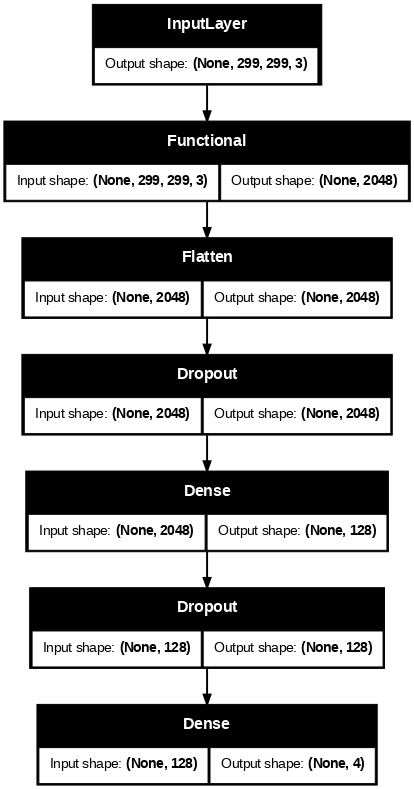

In [14]:
tf.keras.utils.plot_model(model, show_shapes=True, to_file='model.png', dpi=70,)

In [15]:
hist = model.fit(train_data,
                 epochs=5,
                 validation_data=validation_data,
                 shuffle= False)

Epoch 1/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 150s 765ms/step - accuracy: 0.6044 - loss: 1.3295 - precision_1: 0.6419 - recall_1: 0.5325 - val_accuracy: 0.8198 - val_loss: 0.4676 - val_precision_1: 0.8487 - val_recall_1: 0.7710
Epoch 2/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 123s 687ms/step - accuracy: 0.7913 - loss: 0.5357 - precision_1: 0.8348 - recall_1: 0.7500 - val_accuracy: 0.8626 - val_loss: 0.3858 - val_precision_1: 0.8701 - val_recall_1: 0.8183
Epoch 3/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 122s 680ms/step - accuracy: 0.8199 - loss: 0.4527 - precision_1: 0.8474 - recall_1: 0.7945 - val_accuracy: 0.8534 - val_loss: 0.3584 - val_precision_1: 0.8889 - val_recall_1: 0.8183
Epoch 4/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 123s 689ms/step - accuracy: 0.8517 - loss: 0.3993 - precision_1: 0.8763 - recall_1: 0.8276 - val_accuracy: 0.8733 - val_loss: 0.3212 - val_precision_1: 0.8978 - val_recall_1: 0.8580
Epoch 5/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 123s 685ms/step - accuracy: 0.8684 - loss: 0.3764 - precision_1: 0.8833 - rec

In [28]:
len(base_model.layers)

133

In [16]:
base_model.trainable = True
for layer in base_model.layers[:50]:
    layer.trainable = False

model.compile(Adamax(learning_rate= 0.001),
              loss= 'categorical_crossentropy',
              metrics= ['accuracy',
                        Precision(),
                        Recall()])

history_fine = model.fit(train_data,
                 epochs=EPOCH,
                 validation_data=validation_data,
                 shuffle= False)

Epoch 1/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 170s 791ms/step - accuracy: 0.8660 - loss: 0.3979 - precision_2: 0.8854 - recall_2: 0.8376 - val_accuracy: 0.9771 - val_loss: 0.0570 - val_precision_2: 0.9786 - val_recall_2: 0.9756
Epoch 2/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 126s 701ms/step - accuracy: 0.9810 - loss: 0.0659 - precision_2: 0.9831 - recall_2: 0.9769 - val_accuracy: 0.9878 - val_loss: 0.0376 - val_precision_2: 0.9878 - val_recall_2: 0.9878
Epoch 3/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 125s 698ms/step - accuracy: 0.9914 - loss: 0.0317 - precision_2: 0.9914 - recall_2: 0.9904 - val_accuracy: 0.9786 - val_loss: 0.0766 - val_precision_2: 0.9786 - val_recall_2: 0.9786
Epoch 4/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 125s 698ms/step - accuracy: 0.9951 - loss: 0.0190 - precision_2: 0.9952 - recall_2: 0.9947 - val_accuracy: 0.9802 - val_loss: 0.0742 - val_precision_2: 0.9802 - val_recall_2: 0.9802
Epoch 5/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 126s 701ms/step - accuracy: 0.9958 - loss: 0.0155 - precision_2: 0.9958 

In [ ]:
model.save("brain_tumor_xception_classifier.keras")

In [18]:
history_fine.history.keys()

dict_keys(['accuracy', 'loss', 'precision_2', 'recall_2', 'val_accuracy', 'val_loss', 'val_precision_2', 'val_recall_2'])

In [19]:
# Extract metrics
tr_acc = history_fine.history['accuracy']
tr_loss = history_fine.history['loss']
tr_per = history_fine.history['precision_2']
tr_recall = history_fine.history['recall_2']
val_acc = history_fine.history['val_accuracy']
val_loss = history_fine.history['val_loss']
val_per = history_fine.history['val_precision_2']
val_recall = history_fine.history['val_recall_2']

# Get the best epochs for each metric
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
index_precision = np.argmax(val_per)
per_highest = val_per[index_precision]
index_recall = np.argmax(val_recall)
recall_highest = val_recall[index_recall]

# Epochs for plotting
Epochs = [i + 1 for i in range(len(tr_acc))]

# Define a modern style
plt.style.use('ggplot')

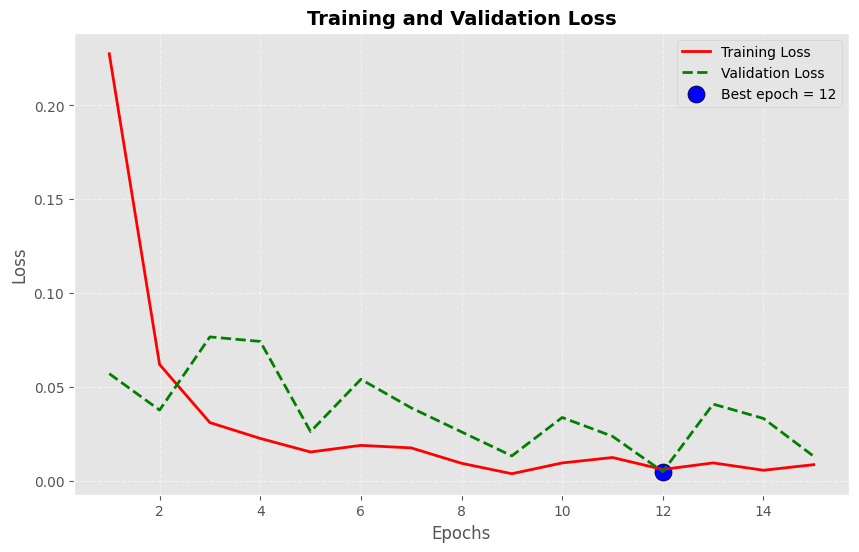

In [20]:
# Plot Training and Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(Epochs, tr_loss, color='red', label='Training Loss', linewidth=2)
plt.plot(Epochs, val_loss, color='green', label='Validation Loss', linestyle='--', linewidth=2)
plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=f'Best epoch = {index_loss + 1}', edgecolors='black')
plt.title('Training and Validation Loss', fontsize=14, fontweight='bold')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=10)
plt.grid(visible=True, linestyle='--', alpha=0.5)
plt.show()

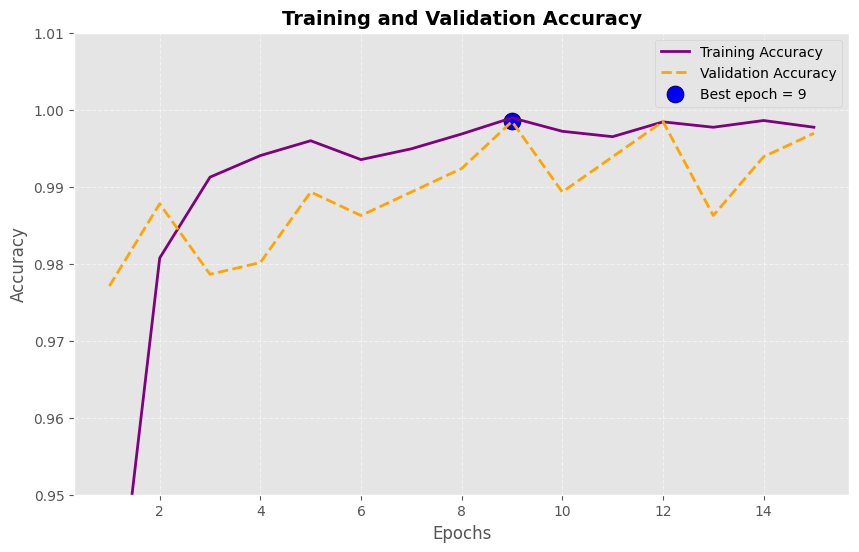

In [21]:
# Plot Training and Validation Accuracy
plt.figure(figsize=(10, 6))
plt.plot(Epochs, tr_acc, color='purple', label='Training Accuracy', linewidth=2)
plt.plot(Epochs, val_acc, color='orange', label='Validation Accuracy', linestyle='--', linewidth=2)
plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=f'Best epoch = {index_acc + 1}', edgecolors='black')
plt.title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(fontsize=10)
plt.ylim(.95, 1.01)
plt.grid(visible=True, linestyle='--', alpha=0.5)
plt.show()

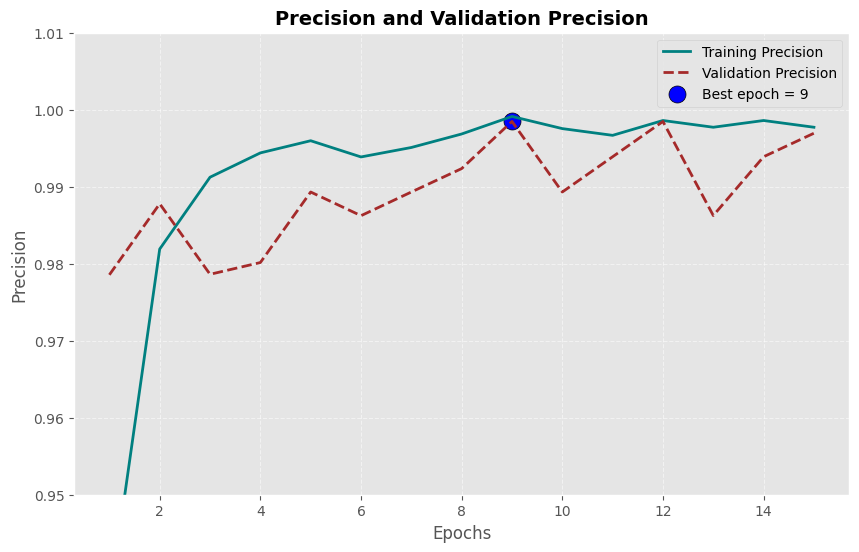

In [22]:
# Plot Precision and Validation Precision
plt.figure(figsize=(10, 6))
plt.plot(Epochs, tr_per, color='teal', label='Training Precision', linewidth=2)
plt.plot(Epochs, val_per, color='brown', label='Validation Precision', linestyle='--', linewidth=2)
plt.scatter(index_precision + 1, per_highest, s=150, c='blue', label=f'Best epoch = {index_precision + 1}', edgecolors='black')
plt.title('Precision and Validation Precision', fontsize=14, fontweight='bold')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.legend(fontsize=10)
plt.ylim(.95, 1.01)
plt.grid(visible=True, linestyle='--', alpha=0.5)
plt.show()

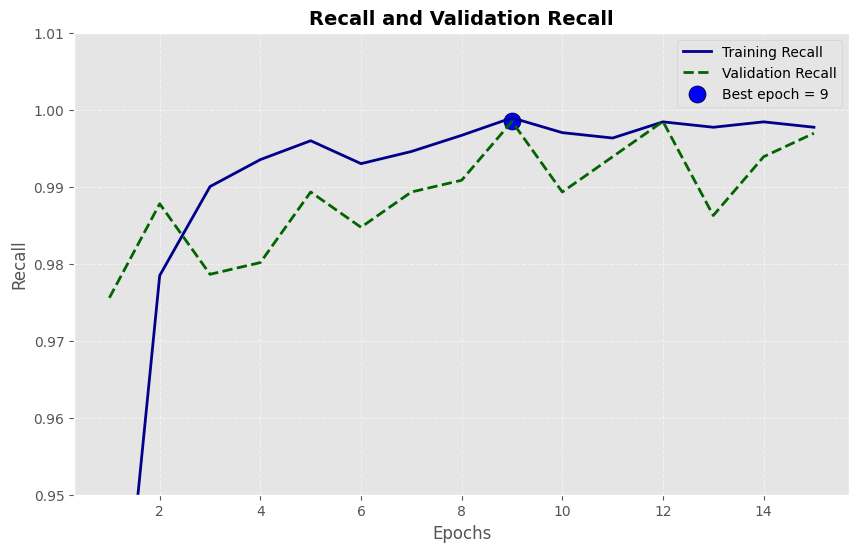

In [23]:
# Plot Recall and Validation Recall
plt.figure(figsize=(10, 6))
plt.plot(Epochs, tr_recall, color='darkblue', label='Training Recall', linewidth=2)
plt.plot(Epochs, val_recall, color='darkgreen', label='Validation Recall', linestyle='--', linewidth=2)
plt.scatter(index_recall + 1, recall_highest, s=150, c='blue', label=f'Best epoch = {index_recall + 1}', edgecolors='black')
plt.title('Recall and Validation Recall', fontsize=14, fontweight='bold')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Recall', fontsize=12)
plt.legend(fontsize=10)
plt.ylim(.95, 1.01)
plt.grid(visible=True, linestyle='--', alpha=0.5)
plt.show()

In [24]:
# Evaluate model on train, validation, and test datasets
train_score = model.evaluate(train_data, verbose=1)
valid_score = model.evaluate(validation_data, verbose=1)
test_score = model.evaluate(test_data, verbose=1)

# Extract accuracy values
accuracies = [train_score[1] * 100, valid_score[1] * 100, test_score[1] * 100]
labels = ["Train Accuracy", "Validation Accuracy", "Test Accuracy"]

# Print Scores
print(f"Train Loss: {train_score[0]:.4f}")
print(f"Train Accuracy: {accuracies[0]:.2f}%")
print('-' * 20)
print(f"Validation Loss: {valid_score[0]:.4f}")
print(f"Validation Accuracy: {accuracies[1]:.2f}%")
print('-' * 20)
print(f"Test Loss: {test_score[0]:.4f}")
print(f"Test Accuracy: {accuracies[2]:.2f}%")

179/179 ━━━━━━━━━━━━━━━━━━━━ 111s 620ms/step - accuracy: 1.0000 - loss: 8.2218e-05 - precision_2: 1.0000 - recall_2: 1.0000
21/21 ━━━━━━━━━━━━━━━━━━━━ 13s 596ms/step - accuracy: 0.9951 - loss: 0.0396 - precision_2: 0.9951 - recall_2: 0.9899
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 275ms/step - accuracy: 0.9974 - loss: 0.0093 - precision_2: 0.9974 - recall_2: 0.9974
Train Loss: 0.0002
Train Accuracy: 100.00%
--------------------
Validation Loss: 0.0240
Validation Accuracy: 99.54%
--------------------
Test Loss: 0.0056
Test Accuracy: 99.85%


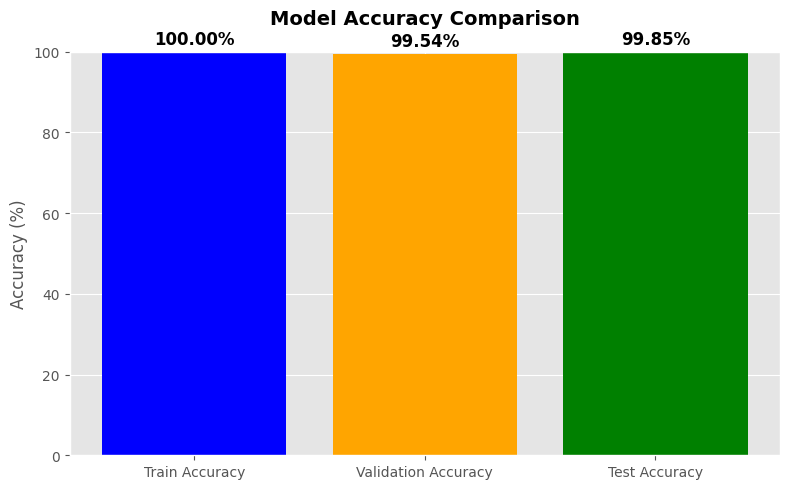

In [25]:
# Plot bar graph
plt.figure(figsize=(8, 5))  # Adjust figure size
bars = plt.bar(labels, accuracies, color=['blue', 'orange', 'green'])
plt.ylim(0, 100)  # Set y-axis limit to 100%
plt.ylabel("Accuracy (%)", fontsize=12)
plt.title("Model Accuracy Comparison", fontsize=14, fontweight='bold', pad=20)  # Add padding to title

# Display values on bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 2, f"{accuracies[i]:.2f}%", ha='center', fontsize=12, fontweight='bold')

# Adjust layout to prevent overlap
plt.tight_layout()

plt.show()

In [26]:
preds = model.predict(test_data)
y_pred = np.argmax(preds, axis=1)

21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 234ms/step


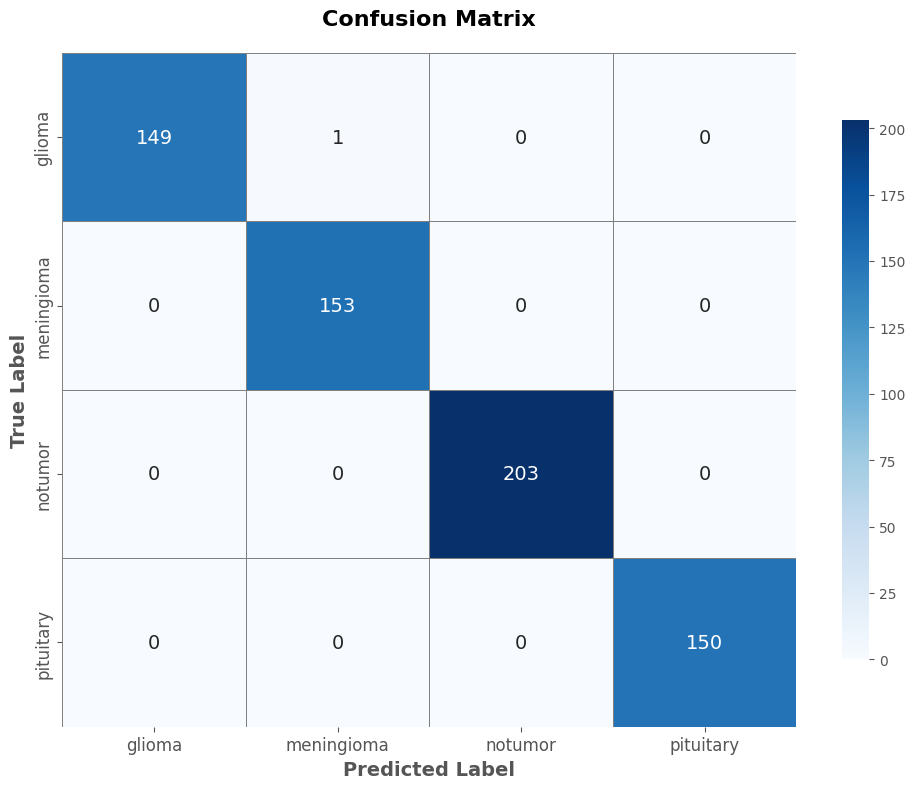

In [27]:
class_dict = train_data.class_indices
cm = confusion_matrix(test_data.classes, y_pred)
labels = list(class_dict.keys())  # Class names

# Plot confusion matrix
plt.figure(figsize=(10, 8))
heatmap = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels,
                      annot_kws={'size': 14}, cbar=True, linewidths=0.5, linecolor='gray',
                      cbar_kws={'shrink': 0.8})  # Add color bar and adjust its size

# Add title and labels
plt.title('Confusion Matrix', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Predicted Label', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=14, fontweight='bold')

# Adjust tick labels
plt.xticks(fontsize=12, rotation=45 if len(labels) > 5 else 0)  # Rotate x-labels if too many
plt.yticks(fontsize=12)

# Improve layout
plt.tight_layout()
plt.show()